<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1>
<center>Прикладные задачи анализа данных</center>
<center>Домашнее задание 2: deep learning для обработки звука</center>
</h1>

## Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы
* Рекуррентными и сверточными классификаторами аудиоданных
* Алгоритмом аугментации аудиоданных SpecAugment

In [1]:
import os
import typing
import random

import tqdm
import torch
import numpy
import wandb
import pandas
import seaborn
import IPython
import torchaudio
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.utils.data as torchdata

wandb.login(anonymous = "allow")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

RANDOM_STATE = 42
def set_random_seed(seed: int = RANDOM_STATE) -> None:
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


cuda


## Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты. 

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов: 

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


### Задание 1 (1 балл). Знакомство с данными.

- Скачайте датасет из [Google Drive](https://drive.google.com/drive/folders/1Q1mgopM_aQToKdSRlTI9zFW83sOqvrCS?usp=sharing) и распакуйте в папку `./data`.
- Положите разархивированные данные рядом с юпитерской тетрадкой. Если вы работаете в колабе, залейте данные на свой гугл-диск и воспользуйтесь кодом ниже для синхронизации тетрадки с ним (это поможет не подгружать их по 10 раз).

- Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

- С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.

In [2]:
classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

In [3]:
class AudioDataset(torchdata.Dataset):
    def __init__(
        self,
        path_to_csv: str,
        path_to_folder: str,
        pad_size: int = 384000,
        sr: int = 44100,
    ):
        self.csv: pandas.DataFrame = pandas.read_csv(path_to_csv)[["ID", "Class"]]
        self.class_to_idx = { classes[i]: i for i in range(len(classes)) }
        self.idx_to_class = { i: classes[i] for i in range(len(classes)) }
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size
        self.sr = sr

    def __getitem__(self, index: int) -> dict:
        id, classname = self.csv.iloc[index]
        wav, sr = torchaudio.load(os.path.join(self.path_to_folder, f'{id}.wav'))

        if sr != self.sr:
            resampler = torchaudio.transforms.Resample(sr, self.sr)
            wav = resampler(wav)

        length = int(wav.shape[1])
        wav = wav.reshape(-1)
        if length < self.pad_size:
            wav = torch.nn.functional.pad(wav, (0, self.pad_size - length), mode = 'constant', value = 0)
            
        return { 'x': wav, 'y': self.class_to_idx[classname], 'len': length }

    def __len__(self) -> int:
        return self.csv.shape[0]

In [4]:
train_dataset = AudioDataset("./data/train_part.csv", "./data/data")
val_dataset = AudioDataset("./data/val_part.csv", "./data/data")

Class: air_conditioner


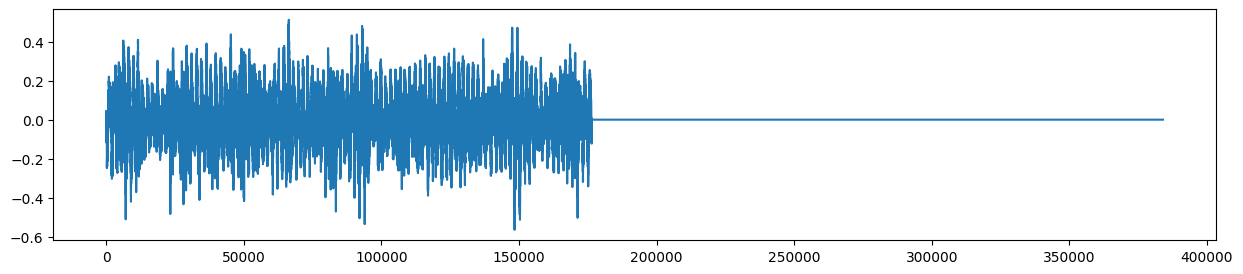

In [5]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

# проверим возращаемые значения __getitem__
item = train_dataset[0]
assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400

# нарисуем и проиграем аудиозаписить
plt.figure(figsize = (15, 3))
plt.plot(item["x"])

print(f'Class: {train_dataset.idx_to_class[item["y"]]}')
IPython.display.Audio(item["x"], rate = train_dataset.sr)

In [6]:
# создадим даталоадеры
train_dataloader = torchdata.DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory = True, drop_last = True)
val_dataloader = torchdata.DataLoader(val_dataset, batch_size = 32, pin_memory = True)

### Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)



По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. 

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_raw.png" height="500">
</center>

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [7]:
class RecurrentRawAudioClassifier(torch.nn.Module):
    def __init__(
        self,
        window_length: int = 1024,
        hop_length: int = 256,
        num_layers: int = 2,
        hidden: int = 256,
        num_classes: int = 10,
    ):
        super().__init__()
        
        self.window_length = window_length
        self.hop_length = hop_length

        self.num_layers = num_layers
        self.hidden = hidden

        self.num_classes = num_classes

        self.first_mlp = torch.nn.Sequential(
            torch.nn.Linear(1024, 256), torch.nn.BatchNorm1d(256), torch.nn.ReLU(),
            torch.nn.Linear(256, 64), torch.nn.BatchNorm1d(64), torch.nn.ReLU(),
            torch.nn.Linear(64, 16)
        )

        self.rnn = torch.nn.LSTM(
            input_size = 16,
            batch_first = True,
            hidden_size = self.hidden,
            bidirectional = True,
            num_layers = self.num_layers
        )

        self.final_mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * self.hidden * self.num_layers, 256), torch.nn.BatchNorm1d(256), torch.nn.ReLU(),
            torch.nn.Linear(256, self.num_classes)
        )

    def forward(self, x: torch.Tensor, lens: torch.Tensor) -> torch.Tensor:
        # разбейте сигнал на окна
        batch_windows = x.unfold(dimension = 1, size = self.window_length, step = self.hop_length)

        # batch_windows.shape == (B, NUM WINDOWS, 1024)
        assert batch_windows.shape[0] == x.shape[0]
        num_windows = batch_windows.shape[1]
        assert batch_windows.shape[2] == self.window_length

        # примените к каждому окну полносвязную сеть
        batch_windows = batch_windows.reshape(-1, self.window_length)
        batch_windows_feautures = self.first_mlp(batch_windows)
        
        # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
        batch_windows_feautures = batch_windows_feautures.reshape((x.shape[0], num_windows, 16))

        # примените к получившемся последовательностям LSTM и возьмите hidden state
        _, (hidden_state, _) = self.rnn(batch_windows_feautures)
        assert hidden_state.shape == (self.num_layers * 2, x.shape[0], self.hidden)

        # склейте hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        hidden_flattened = torch.cat([ *hidden_state ], dim = 1)
        assert hidden_flattened.shape == (x.shape[0], 2 * self.hidden * self.num_layers)

        return self.final_mlp(hidden_flattened)
    
    def num_params(self) -> int:
        return sum(p.numel() for p in self.parameters())

In [8]:
def test_classifier():
    x, y, len = next(iter(train_dataloader)).values()
    assert RecurrentRawAudioClassifier()(x, len).shape == (32, 10)
test_classifier()

Обучим получившуюся модель.

In [9]:
def train_audio_clfr(
    name: str,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataloader: torchdata.DataLoader,
    
    num_epochs: int = 10,
    device: torch.device = DEVICE,
    augmentation: typing.Optional[typing.Callable] = None,
    data_transform: typing.Optional[typing.Callable] = None,
    criterion: typing.Callable = torch.nn.CrossEntropyLoss(),
):
    model.train()
    model.to(device)
    
    # Start wandb
    wandb.init(project = "ADS-HW-2", name = name, anonymous = "allow", config = {
        'model': str(model),
        'criterion': str(criterion),
        'optimizer': str(optimizer)
    })
    wandb.watch(model, log = "all")

    for epoch in tqdm.trange(num_epochs):
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применяем преобразование входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device = device, sr = train_dataloader.dataset.sr)

            # примеменяем к логмелспектрограмме аугментацию
            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()
            
            wandb.log({
                'Train loss': loss.item(),
                'Train accuracy': (probs.argmax(dim = -1) == y).float().mean().item()
            })
            
    wandb.finish() # Finish wandb run

In [10]:
set_random_seed()

# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
optim = torch.optim.Adam(rnn_raw.parameters(), lr = 3e-4)

# обучим модель
train_audio_clfr(
    'rnn_raw',
    rnn_raw,
    optim,
    train_dataloader
)

100%|██████████| 10/10 [09:08<00:00, 54.83s/it]


Train accuracy,▁▁▁▃▅▄▂▄▄▅▃▄▅▅▄▄▇▅▅▅▄▅▅▅▆▇▇▇▆▆▇▇▇▇▆█▆▆▇▆
Train loss,██▇▇▆▆█▆▅▅▆▅▄▅▅▄▃▄▄▄▄▃▂▄▃▁▁▂▂▃▂▂▁▁▄▁▁▃▁▃
Train accuracy,0.8125
Train loss,0.76261


![Alternative Text][1712950352152]

[1712950352152]: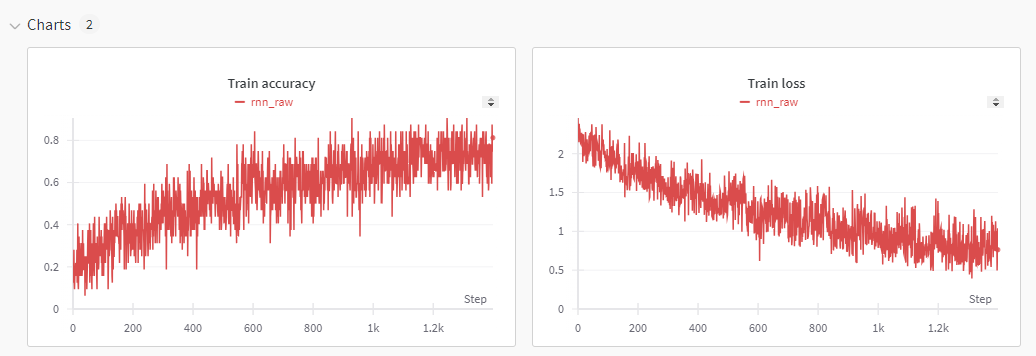

Посчитаем метрики на валидационном датасете.

In [11]:
def plot_confusion_matrix(
    model: torch.nn.Module,
    val_dataloader: torchdata.DataLoader,
    
    device: torch.device = DEVICE,
    data_transform: typing.Optional[typing.Callable] = None,
):
    model.eval()
    model.to(device)

    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, device = device, sr = val_dataloader.dataset.sr)

            probs = model(x, lens)
            pred_cls = probs.argmax(dim = -1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {numpy.mean([ p[0] == p[1] for p in pred_true_pairs ])}")

    cm_df = pandas.DataFrame(
        sklearn.metrics.confusion_matrix(
            [ p[1] for p in pred_true_pairs ],
            [ p[0] for p in pred_true_pairs ],
            normalize = "true",
        ),
        columns = classes,
        index = classes,
    )
    seaborn.heatmap(cm_df, annot = True)

Val accuracy: 0.3572192513368984


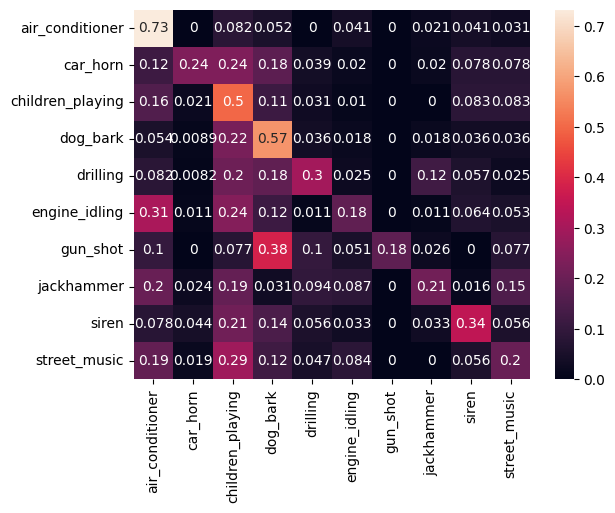

In [12]:
plot_confusion_matrix(rnn_raw, val_dataloader)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

In [13]:
print('Parameters:', rnn_raw.num_params())

Parameters: 2684122


*Ответ* : сильно. Точность на тренировочной выборке достигает `0.8`, а на валидационной - лишь `0.35`. Причина, скорее всего, в переобучении: модель содержит более 2.5 млн. параметров, а тренировочная выборка - лишь 4500 записей. Более того, модель принимает на вход "сырую" аудиозапись, которая содержит много "шума" - лишней информации, которая мешает обучению.

### Задание 3. Построение Мел-cпектрограмм. (2 балла)



Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

<center>
<img src="https://antkillerfarm.github.io/images/img2/Spectrogram_5.png" height="550">
</center>

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [14]:
N_FFT = 1024
WIN_LENGTH = 1024
HOP_LENGTH = 256
N_MELS = 64

In [15]:
# референсная функця
def compute_log_melspectrogram_reference(
    wav_batch: torch.Tensor,
    lens: torch.Tensor,
    sr: int,
    device: torch.device = DEVICE
):
    featurizer = torchaudio.transforms.MelSpectrogram(
        sample_rate = sr,
        n_fft = N_FFT,
        win_length = WIN_LENGTH,
        hop_length = HOP_LENGTH,
        n_mels = N_MELS,
        center = False,
    ).to(device)
    return torch.log(featurizer(wav_batch.to(device)).clamp(1e-5)), lens // 256

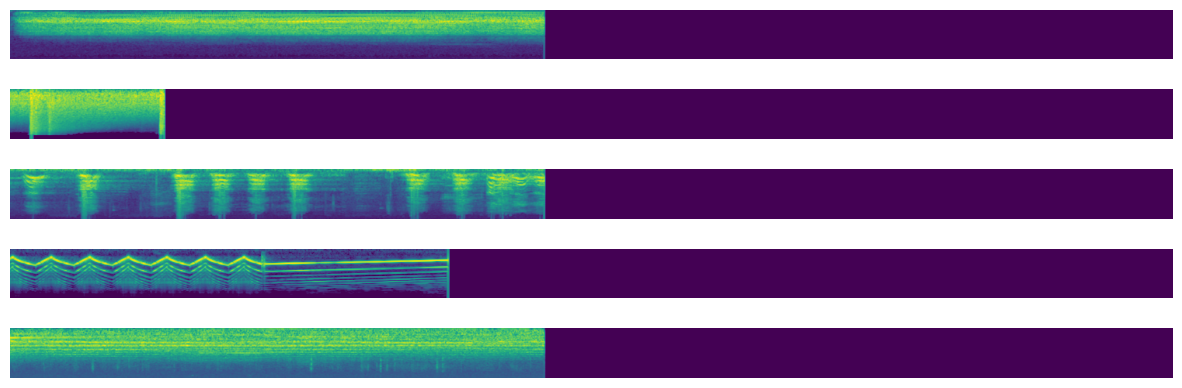

In [16]:
set_random_seed()

# возьмем случайный батч
batch = next(iter(train_dataloader))
wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize = (15, 5))
for ax, log_mel in zip(axes, log_melspect):
    ax.imshow(log_mel.cpu().numpy())
    ax.axis("off")

Теперь сделаем то же самое сами. 


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [17]:
windows = wav_batch.unfold(dimension = 1, size = WIN_LENGTH, step = HOP_LENGTH)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

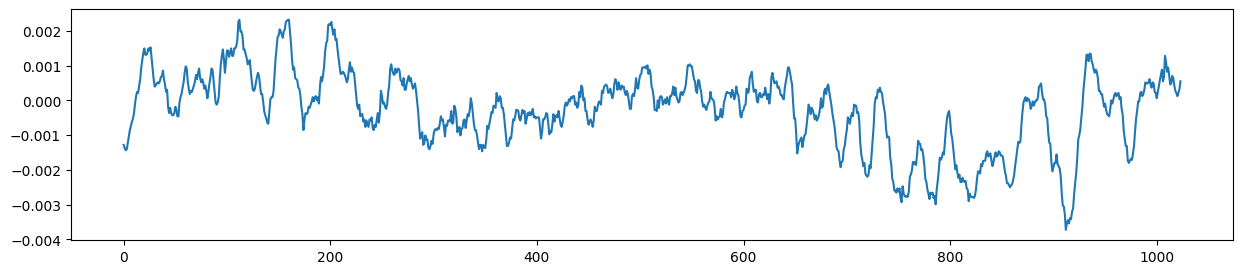

In [18]:
plt.figure(figsize = (15, 3))
plt.plot(windows[0, 0])
IPython.display.Audio(windows[0, 0], rate = train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [19]:
filter = torch.hann_window(WIN_LENGTH)
windows_with_applied_filter = windows * filter[None, None, :]
assert windows_with_applied_filter.shape == (32, 1497, 1024)

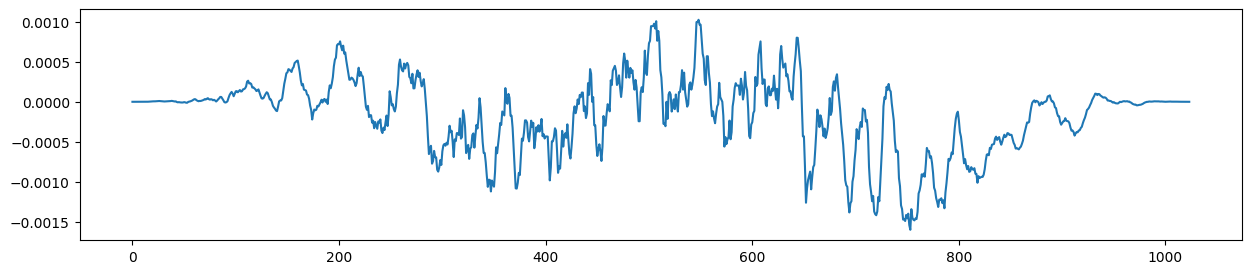

In [20]:
plt.figure(figsize = (15, 3))
plt.plot(windows_with_applied_filter[0, 0])
IPython.display.Audio(windows_with_applied_filter[0, 0], rate = train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [21]:
fft_features = torch.fft.fft(windows_with_applied_filter)[:, :, :N_FFT // 2 + 1]
fft_magnitudes = torch.abs(fft_features ** 2)
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [22]:
melscale = torchaudio.transforms.MelScale(
    n_mels = N_MELS,
    sample_rate = train_dataset.sr,
    n_stft = N_FFT // 2 + 1
)

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

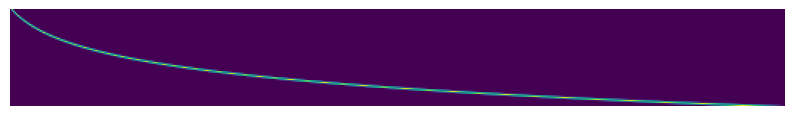

In [23]:
plt.figure(figsize = (10, 2))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())
plt.show()

Примените Мел-шкалу к магнитудам.

In [24]:
mel_spectrogram = melscale(fft_magnitudes.permute(0, 2, 1))
assert mel_spectrogram.shape == (32, 64, 1497)

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [25]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

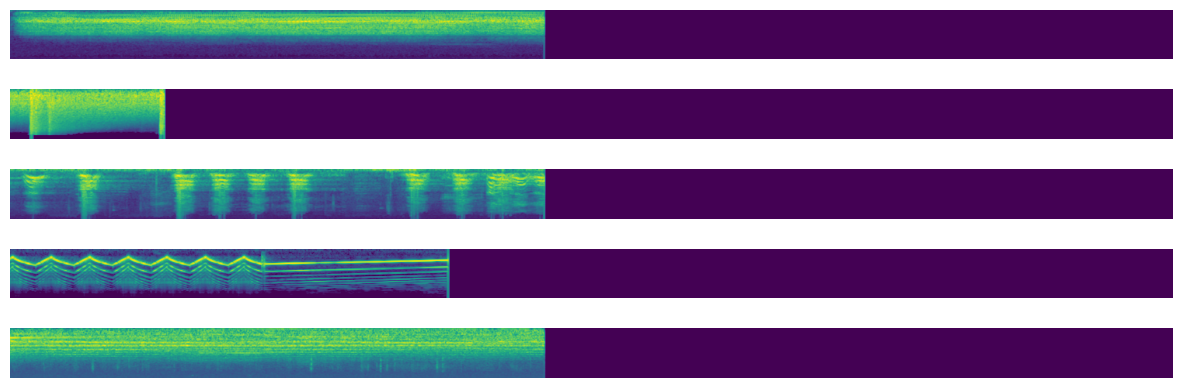

In [26]:
# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize = (15, 5))
for ax, log_mel in zip(axes, logmel_spectrogram):
    ax.imshow(log_mel.cpu().numpy())
    ax.axis("off")

Теперь оформим эту логику в функцию.

In [27]:
# ваша реализация
def compute_log_melspectrogram(
    wav_batch: torch.Tensor,
    lens: torch.Tensor,
    sr: int,
    device: torch.device = DEVICE
):
    wav_batch = wav_batch.to(device)
    windows = wav_batch.unfold(dimension = 1, size = WIN_LENGTH, step = HOP_LENGTH)

    filter = torch.hann_window(WIN_LENGTH).to(device)
    windows_with_applied_filter = windows * filter[None, None, :]

    n_stft = N_FFT // 2 + 1
    fft_features = torch.fft.fft(windows_with_applied_filter)[:, :, :n_stft]
    fft_magnitudes = torch.abs(fft_features ** 2)
    
    melscale = torchaudio.transforms.MelScale(n_mels = N_MELS, sample_rate = sr, n_stft = n_stft).to(device)
    mel_spectrogram = melscale(fft_magnitudes.permute(0, 2, 1))
    return torch.log(mel_spectrogram.clamp(1e-5)), lens // 256

Финальная проверка.

In [28]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol = 1e-5,
)

### Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_mel.png" height="500">
</center>

**За реализацию архитектуры дается 0.5 балла.**

In [29]:
class RecurrentMelSpectClassifier(torch.nn.Module):
    def __init__(
        self,
        num_layers: int = 2,
        hidden: int = 256,
        num_classes: int = 10,
    ):
        super().__init__()
    
        self.num_layers = num_layers
        self.hidden = hidden

        self.num_classes = num_classes

        self.rnn = torch.nn.LSTM(
            input_size = 64,
            batch_first = True,
            hidden_size = self.hidden,
            bidirectional = True,
            num_layers = self.num_layers
        )

        self.final_mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * self.hidden * self.num_layers, 256), torch.nn.BatchNorm1d(256), torch.nn.ReLU(),
            torch.nn.Linear(256, self.num_classes)
        )

    def forward(self, x: torch.Tensor, lens: torch.Tensor) -> torch.Tensor:
        # примените к получившемся последовательностям LSTM и возьмите hidden state
        _, (hidden_state, _) = self.rnn(x.permute(0, 2, 1)) # your code here
        assert hidden_state.shape == (self.num_layers * 2, x.shape[0], self.hidden)

        # склейте hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        hidden_flattened = torch.cat([ *hidden_state ], dim = 1)
        assert hidden_flattened.shape == (x.shape[0], 2 * self.hidden * self.num_layers)

        return self.final_mlp(hidden_flattened)
    
    def num_params(self) -> int:
        return sum(p.numel() for p in self.parameters())

In [30]:
set_random_seed()

# создадим объекты модели и оптимизатор
rnn_mel = RecurrentMelSpectClassifier()
optim = torch.optim.Adam(rnn_mel.parameters(), lr = 3e-4)

# обучим модель
train_audio_clfr(
    'rnn_mel',
    rnn_mel,
    optim,
    train_dataloader,
    data_transform = compute_log_melspectrogram
)

100%|██████████| 10/10 [08:49<00:00, 52.93s/it]


Train accuracy,▁▃▅▄▅▅▄▅▆▆▆▆▆▇▇▆▆▇▆▆▆▆▇▆▆█▇▆▆▇█▇▇▇▆▆█▆█▇
Train loss,█▅▅▄▄▄▅▄▃▃▃▃▃▂▃▃▂▂▂▂▃▂▁▃▂▂▂▃▂▂▁▂▂▂▂▂▁▂▁▁
Train accuracy,0.9375
Train loss,0.17429


![Alternative Text][1712950405242]

[1712950405242]: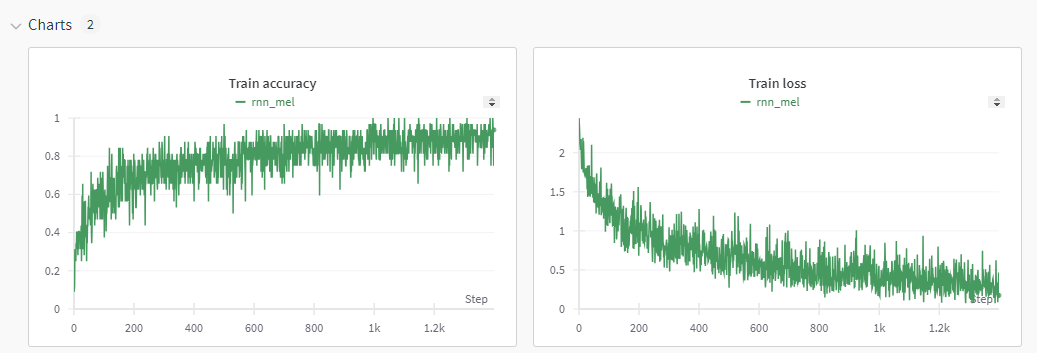

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

Val accuracy: 0.813903743315508


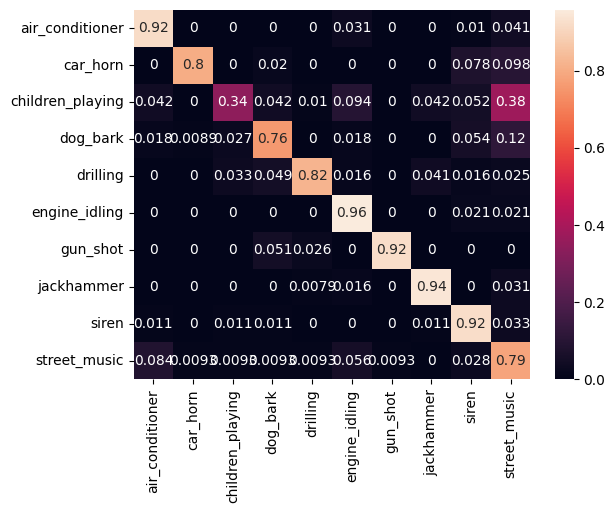

In [31]:
plot_confusion_matrix(rnn_mel, val_dataloader, data_transform = compute_log_melspectrogram)

In [32]:
print('Parameters:', rnn_mel.num_params())

Parameters: 2501898


### Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [33]:
class CNN10(torch.nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()

        self.cnn_backbone = torch.nn.Sequential(
            # 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
            torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3), torch.nn.BatchNorm2d(16), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3), torch.nn.BatchNorm2d(16), torch.nn.ReLU(),
            # MaxPoll 2x2
            torch.nn.MaxPool2d(kernel_size = 2),
            # 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
            torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3), torch.nn.BatchNorm2d(32), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3), torch.nn.BatchNorm2d(32), torch.nn.ReLU(),
            # MaxPoll 2x2
            torch.nn.MaxPool2d(kernel_size = 2),
            # 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3), torch.nn.BatchNorm2d(64), torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3), torch.nn.BatchNorm2d(64), torch.nn.ReLU(),
            # MaxPoll 2x2
            torch.nn.MaxPool2d(kernel_size = 2),
            # (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
            torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3), torch.nn.BatchNorm2d(128), torch.nn.ReLU(),
            # (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 2), torch.nn.BatchNorm2d(128), torch.nn.ReLU(),
        )

        self.final_mlp = torch.nn.Sequential(
            # Fully Connected 128, ReLU
            torch.nn.Linear(128, 128), torch.nn.ReLU(),
            # Fully Connected 10
            torch.nn.Linear(128, num_classes)
        )

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        # Global MaxPoll
        z = torch.nn.functional.max_pool2d(z, kernel_size = z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)
    
    def num_params(self) -> int:
        return sum(p.numel() for p in self.parameters())

In [34]:
set_random_seed()

# создадим объекты модели и оптимизатор
cnn = CNN10()
optim = torch.optim.Adam(cnn.parameters(), lr = 3e-4)

# обучим модель
train_audio_clfr(
    'cnn',
    cnn,
    optim,
    train_dataloader,
    data_transform = compute_log_melspectrogram,
    num_epochs = 20
)

100%|██████████| 20/20 [08:03<00:00, 24.18s/it]


Train accuracy,▁▃▄▅▆▅▆▇▇▆▆▆█▆▇█▇████████████████████▇██
Train loss,█▆▅▄▃▄▃▂▂▃▃▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train accuracy,1.0
Train loss,0.00927


![Alternative Text][1712950427354]

[1712950427354]: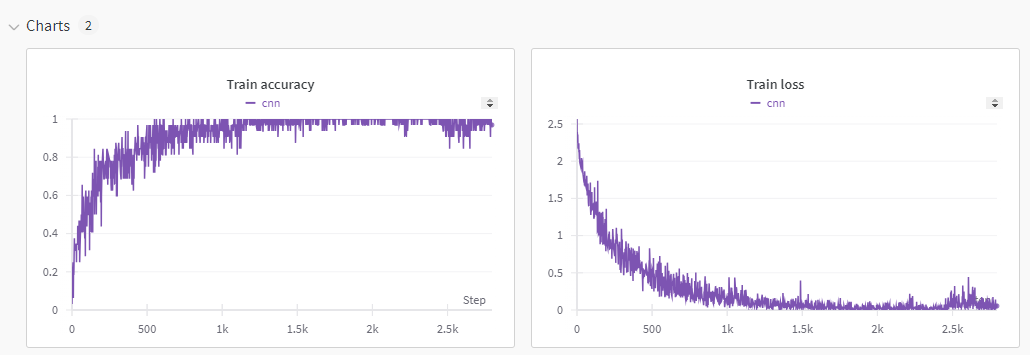

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Val accuracy: 0.9090909090909091


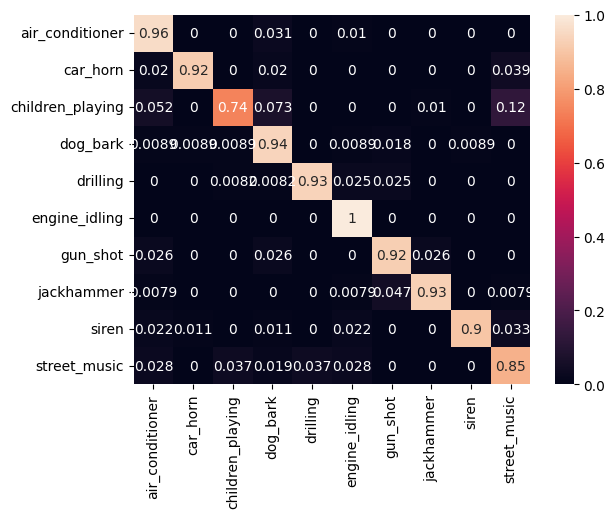

In [35]:
plot_confusion_matrix(cnn, val_dataloader, data_transform = compute_log_melspectrogram)

In [36]:
print('Parameters:', cnn.num_params())

Parameters: 230074


### Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [37]:
class SpectAugment:
    def __init__(
        self,
        filling_value: typing.Union[str, int] = "mean",

        n_time_masks: int = 2,
        max_time: int = 50,

        n_freq_masks: int = 2,
        max_freq: int = 10,
    ):
        self.filling_value = filling_value

        self.n_time_masks = n_time_masks
        self.max_time = max_time

        self.n_freq_masks = n_freq_masks
        self.max_freq = max_freq

    def __call__(self, spect: torch.Tensor, lens: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        spect = spect.clone()
        for item in spect:
            match self.filling_value:
                case 'mean': value = item.mean()
                case 'min': value = item.min()
                case 'max': value = item.max()
                case _: item = self.filling_value

            for _ in range(self.n_freq_masks):
                size = random.randint(0, self.max_freq)
                start = random.randint(0, item.shape[0] - size)
                item[start:start + size, :] = value

            for _ in range(self.n_time_masks):
                size = random.randint(0, self.max_time)
                start = random.randint(0, item.shape[1] - size)
                item[:, start:start + size] = value
                
        return spect, lens

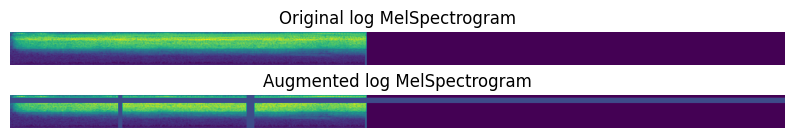

In [38]:
set_random_seed()

# возьмем случайный батч
batch = next(iter(train_dataloader))
wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
logmel, lens = compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)

# применим аугментацию к данным
logmel_augmented, lens = SpectAugment()(logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize = (10, 1.5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(logmel_augmented[0].cpu().numpy())

plt.show()

In [39]:
set_random_seed()

# создадим объекты модели и оптимизатор
cnn_aug = CNN10()
optim = torch.optim.Adam(cnn_aug.parameters(), lr = 3e-4)

# обучим модель
train_audio_clfr(
    'cnn_aug',
    cnn_aug,
    optim,
    train_dataloader,
    data_transform = compute_log_melspectrogram,
    augmentation = SpectAugment(max_time = 100, max_freq = 5),
    num_epochs = 20
)

100%|██████████| 20/20 [08:29<00:00, 25.46s/it]


Train accuracy,▁▃▄▅▅▄▆▆▆▆▆▆▇▇▇█▆▇▇▇▇▇███▆▇▇▇██▇▇███▇▇█▇
Train loss,█▇▅▄▄▄▃▃▃▃▄▃▂▂▂▁▂▂▃▁▂▂▂▁▂▃▁▂▂▁▁▂▁▁▁▁▁▁▁▂
Train accuracy,0.96875
Train loss,0.11546


![Alternative Text][1712950666002]

[1712950666002]: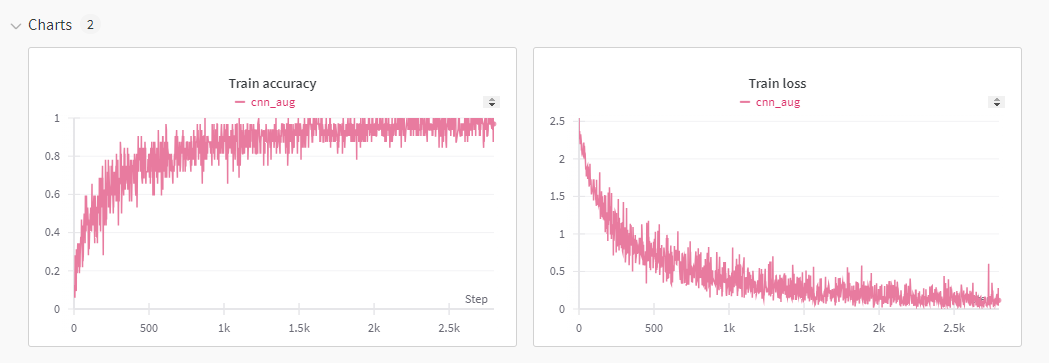

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Val accuracy: 0.9240641711229947


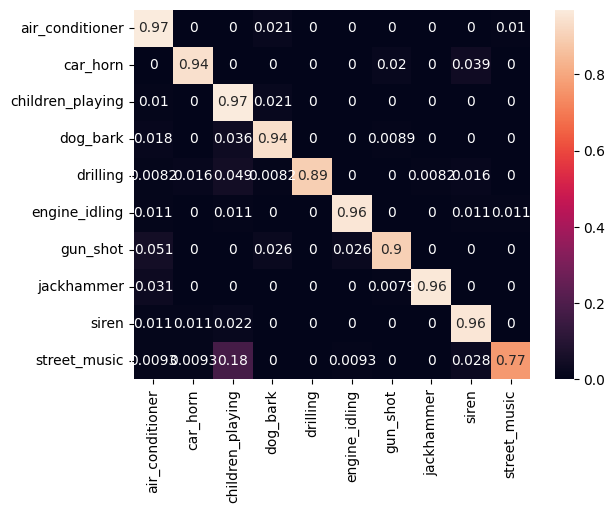

In [40]:
plot_confusion_matrix(cnn_aug, val_dataloader, data_transform = compute_log_melspectrogram)

In [41]:
print('Parameters:', cnn_aug.num_params())

Parameters: 230074
